Using the dataset for Microsoft's stock data found at here: https://www.kaggle.com/datasets/varpit94/microsoft-stock-data

# **Task 2**

I am using a stock dataset consisting of the Open, High, Low, Volume, and Close stock price of Microsoft from 1986 to 2022. Stock prices follow a time series because it ultimately does follow a trend and it always depends on the previous few days values because if the stock is overvalued, it would go down. If it is undervalued, it would surely go up. Stocks also follow a cyclical seasonal trend depending on months when rates are lowest and highest. If you have a sufficient enough data of a stock's previous data values, you could predict what would happen in the future. In this case, we aren't doing something that grand but we will predict the Close value of a stock given the previous data values and Open, High, Low, Volumes of the day.

**Part 1**

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler # To scale our data

In [28]:
df = pd.read_csv("/kaggle/input/microsoft-stock-data/MSFT.csv").drop(columns=['Adj Close']) # We'll get rid of Adj Close because it is very similar to Close anyway
df

,Date,Open,High,Low,Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,47894400
...,...,...,...,...,...,...
9078,2022-03-18,295.369995,301.000000,292.730011,300.429993,43317000
9079,2022-03-21,298.890015,300.140015,294.899994,299.160004,28351200
9080,2022-03-22,299.799988,305.000000,298.769989,304.059998,27599700
9081,2022-03-23,300.510010,303.230011,297.720001,299.489990,25715400


A cursory glance shows us that the data as is cannot be given into a model as some values are much larger than others. Volume is much larger than any other value so we have to **scale** our data.

In [29]:
col_list = list(df.columns)
x, y = col_list.index("Close"), col_list.index("Volume")   # We'll just switch Volume and Close because we'll be predicting Close not Volume
col_list[y], col_list[x] = col_list[x], col_list[y]
df = df[col_list]

In [30]:
scaler = MinMaxScaler()  # scaler = (data-min(data))/(max(data)-min(data))

In [31]:
df[df.columns[1:]] = scaler.fit_transform(df[df.columns[1:]])  # Don't want to scale our date
df.head()

,Date,Open,High,Low,Volume,Close
0,1986-03-13,0.000000,0.000027,0.000000,1.000000,0.000020
1,1986-03-14,0.000025,0.000030,0.000025,0.297096,0.000030
2,1986-03-17,0.000035,0.000032,0.000036,0.127119,0.000035
3,1986-03-18,0.000040,0.000032,0.000030,0.063588,0.000028
4,1986-03-19,0.000033,0.000025,0.000025,0.044285,0.000023


Now our data looks a lot more clean and similar :)

In [7]:
xst = np.array(df.iloc[:, 1:5])
yst = np.array(df.iloc[:, -1])

In [8]:
seq_length = 21             # We'll have about 21 days of data fed into our RNN models since the market should react to 
                            # new information in about 3 weeks

In [9]:
X = []
Y = []
for i in range(len(df)-seq_length):
    X.append(xst[i:i+seq_length])   # 3 weeks of data
    Y.append(yst[i+seq_length])     # Close value after 3 weeks
X = np.array(X)
Y = np.array(Y)

We'll split our data into 70% - 15% - 15% respectively for our train val test sets

In [33]:
train_X = torch.FloatTensor(X[:int(0.7*len(X))])
train_Y = torch.FloatTensor(Y[:int(0.7*len(Y))])

val_X = torch.FloatTensor(X[int(0.7*len(X)):int(0.85*len(X))])
val_Y = torch.FloatTensor(Y[int(0.7*len(Y)):int(0.85*len(Y))])

test_X = torch.FloatTensor(X[int(0.85*len(X)):])
test_Y = torch.FloatTensor(Y[int(0.85*len(Y)):])

In [34]:
train_X.shape, val_X.shape, test_X.shape

(torch.Size([6343, 21, 4]),
 torch.Size([1359, 21, 4]),
 torch.Size([1360, 21, 4]))

We'll make our RNN class using pytorch. We'll use the RNN layer. It will have an input dimension of 4 and a hidden layer dimension of 10 with only 1 layer. During RNN, our layer will automatically pass into a TanH activation function to avoid exploding gradients.

After passing through our RNN layer, we will have a fully connected layer to pass our hidden layer into to pass out a value.

In [39]:
class RNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(RNN, self).__init__()
        
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        features, _status = self.rnn(x)
        
        features = self.fc(features[:, -1])
        
        return features.view(-1)

net = RNN(4, 10, 1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)

We will pass our data through our model for 100 epochs all at once.

In [40]:
epochs = 100
losses = []

for i in range(epochs):
    optimizer.zero_grad()
    outputs = net(train_X)
    loss = criterion(outputs, train_Y)
    loss.backward()
    optimizer.step()
    
    loss = criterion(net(train_X), train_Y)     # We are saving our loss values and printing them out in intervals to see 
                                                # our loss shrink over time
    losses.append(loss.item())                  # We will even save it in a list to graph it out later
    if i%50 == 0:
        print(i, '\t', loss.item())

0 	 0.0038578466046601534
50 	 2.6091764084412716e-05


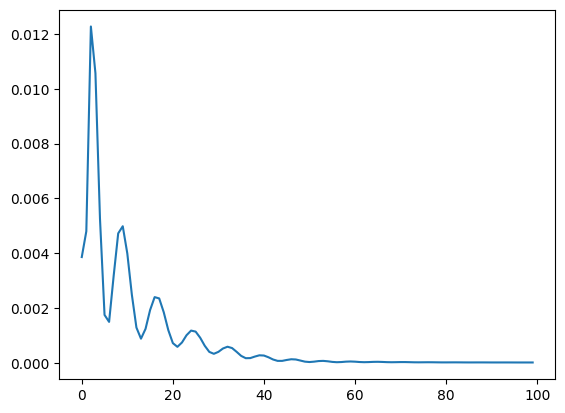

In [41]:
plt.plot(losses)
plt.show()

Our loss graph for our validation set was going down and up at first but eventually stabilized close to 0

Now, let's test it on our test set

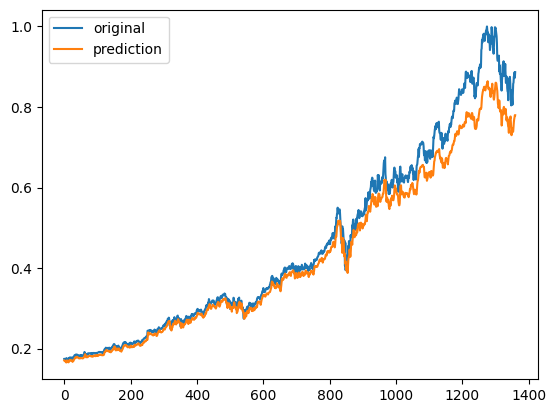

In [42]:
plt.plot(test_Y)
plt.plot(net(test_X).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

We got a very, very accurate output!

**Part 2**

Now let's try our code using LSTM. It will have the same architecture as our RNN layer.

In [46]:
class RNN_LSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(RNN_LSTM, self).__init__()
        
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        features, _status = self.lstm(x)
        
        features = self.fc(features[:, -1])
        
        return features.view(-1)

net = RNN_LSTM(4, 10, 1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)

In [47]:
epochs = 100
losses = []

for i in range(epochs):
    optimizer.zero_grad()
    outputs = net(train_X)
    loss = criterion(outputs, train_Y)
    loss.backward()
    optimizer.step()
    
    loss = criterion(net(train_X), train_Y)
    losses.append(loss.item())
    if i%20 == 0:
        print(i, '\t', loss.item())

0 	 0.0025825249031186104
20 	 0.0009949598461389542
40 	 0.0001862060307757929
60 	 2.594997567939572e-05
80 	 6.175057933432981e-06


It took a lot longer. As expected if you're embedding your inputs and passing them through multiple gates. However, we got a pretty good low loss value. Our loss curve looks pretty good, as shown below. It did not go down as fast as our RNN one but this is pretty nice.

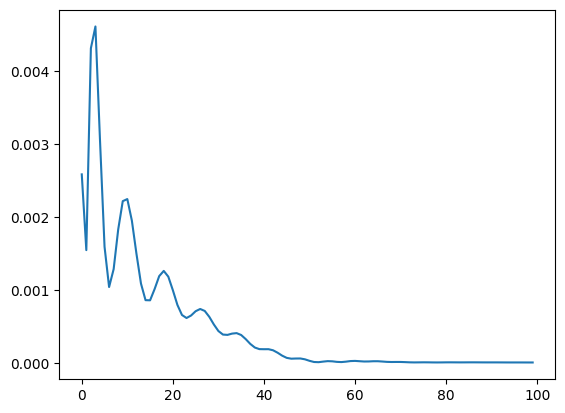

In [51]:
plt.plot(losses)
plt.show()

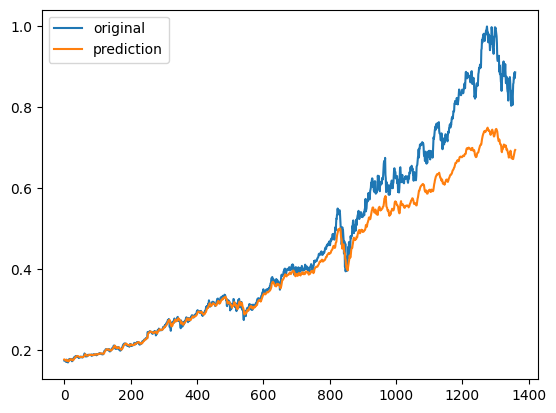

In [52]:
plt.plot(test_Y)
plt.plot(net(test_X).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

Our test set also has pretty great results although it is not as good as our RNN result. I believe that this is due to slight overfitting. LSTM pays very close attention to certain aspects of our training data but the economic market is fickle and is prone to inflation. Perhaps our LSTM model could not predict the fast rate of inflating prices in the early 2020's.

Now we will build our GRU model. It is architecturally the same as the RNN model but uses gates like the LSTM model.

In [62]:
class RNN_GRU(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(RNN_GRU, self).__init__()
        
        self.gru = torch.nn.GRU(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        features, _status = self.gru(x)
        
        features = self.fc(features[:, -1])
        
        return features.view(-1)

net = RNN_GRU(4, 10, 1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)

In [63]:
epochs = 100
losses = []

for i in range(epochs):
    optimizer.zero_grad()
    outputs = net(train_X)
    loss = criterion(outputs, train_Y)
    loss.backward()
    optimizer.step()
    
    loss = criterion(net(train_X), train_Y)
    losses.append(loss.item())
    if i%20 == 0:
        print(i, '\t', loss.item())

0 	 0.002114041242748499
20 	 0.00018011983775068074
40 	 2.623624459374696e-05
60 	 6.41693713987479e-06
80 	 3.922624273400288e-06


The loss values didn't go down as fast as RNN or LSTM but they went down pretty well. A lot of computation can slow down progress after all. As shown below, the curve is rather good.

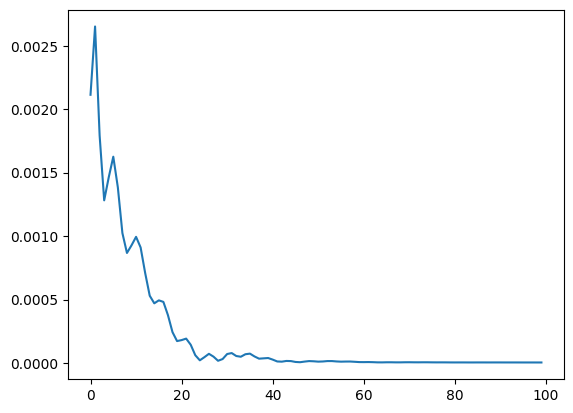

In [64]:
plt.plot(losses)
plt.show()

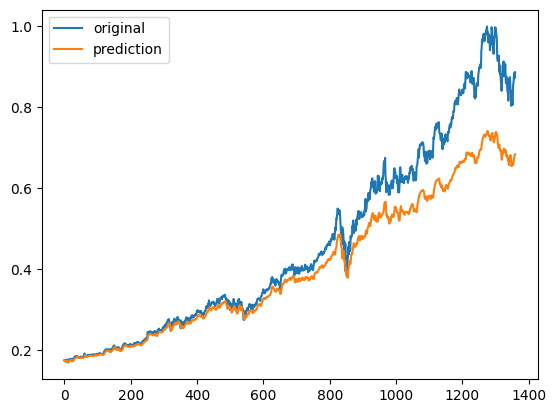

In [65]:
plt.plot(test_Y)
plt.plot(net(test_X).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

The GRU model was very similar to the LSTM. It also diverged from the original stock prices after a few iterations into the test set. This makes sense since GRU is a simplified LSTM that holds less "memory" than LSTM and is bound to stick to the 2010's level of inflation rates.

**Part 3**

No I do not believe that traditional feed forward networks are able to achieve results like this without a lot of parameters and a lot of training. The sole reason is because of the element of "time." All the data cannot be presented at once for feed forward networks but one must consider the past to predict the future. Without appropriate "attention" for past data, it is difficult to predict the future, that is why RNN's which consider the past data are capable of predicting the future.

# **Task 3**

We will use the gensim model and download word2vec-google-news-300

In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[====----------------------------------------------] 9.7% 160.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 15.7% 261.2/1662.8MB downloaded

Took quite a bit, and we couldn't even download everything fully. Oh well, we'll try to accomplish things with what we've got.

Let's define a cosine similarity function.

In [26]:
def cosine_similarity(a,b):
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

A cosine similarity function effectively plots two points on an n-dimensional graph and calculates the most acute angle possible between them. If they are similar, the value would be close to 1. If they are different, the value returned would be close to 0.

In [66]:
cosine_similarity(wv['king'], wv['queen'])

0.6510956610004666

*king* and *queen* are on the close side

In [67]:
cosine_similarity(wv['car'], wv['cat'])

0.21528184382331872

*car* and *cat*, despite being very similar words, are not very close

In [68]:
cosine_similarity(wv['apple'], wv['apple'])

0.9999999999999998

The same word are very, very similar so we get a very high output

In [71]:
cosine_similarity(wv['home'], wv['house'])

0.5617802429905374